# Image Caption Generation

## Import Libraries

In [1]:
import csv, re, os, pickle, random
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, SimpleRNN, GRU, Bidirectional, Concatenate, Dense, Embedding, Dropout, add, Add

Check if GPU is available and Set TensorFlow to run on GPU

In [2]:
# Check if GPU is available and set TF to run on GPU
if tf.test.gpu_device_name():
    print('Default GPU Device:', tf.test.gpu_device_name())
else:
    print("No GPU detected. TensorFlow will run on CPU.")

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Default GPU Device: /device:GPU:0


## Load Captions and Images

Dataset and captions are available on Google Drive at [Flicker8K Dataset](https://drive.google.com/drive/folders/1Vj8DXJoxufcv6iPFzpBOpUOQuc0eYeFc?usp=drive_link)         

Download the dataset and captions, and update the directory and captions_file variables below accordingly.


In [3]:
#Load Captions and extract Image IDs
directory = '/content/drive/MyDrive/Colab Notebooks/Flickr8k Dataset/Images'
captions_file = '/content/drive/MyDrive/Colab Notebooks/Flickr8k Dataset/captions.txt'

def load_captions(captions_file):
    captions_dict = {}

    with open(captions_file, 'r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip header row
        for row in reader:
            image_id, caption = row
            image_id = image_id.split('.')[0]  # Remove file extension '.jpg'
            if image_id not in captions_dict:
                captions_dict[image_id] = []
            captions_dict[image_id].append(caption.strip())

    return list(captions_dict.keys()), captions_dict

image_ids, captions = load_captions(captions_file)

### Pre-process Captions

In [4]:
# Pre-process captions

def preprocess_captions(captions):
    preprocessed_captions = {}
    for img_id, img_captions in captions.items():
        preprocessed_captions[img_id] = []
        for caption in img_captions:
            # Remove special characters using regex
            caption = re.sub(r'[^\w\s]', '', caption.lower())
            # Add sos at the start and eos at the end
            caption = 'sos ' + caption.strip() + ' eos'
            preprocessed_captions[img_id].append(caption)
    return preprocessed_captions

processed_captions = preprocess_captions(captions)

In [5]:
# Print pre-processed captions
processed_captions[image_ids[0]]

['sos a child in a pink dress is climbing up a set of stairs in an entry way eos',
 'sos a girl going into a wooden building eos',
 'sos a little girl climbing into a wooden playhouse eos',
 'sos a little girl climbing the stairs to her playhouse eos',
 'sos a little girl in a pink dress going into a wooden cabin eos']

## Tokenize Captions

In [6]:
# Tokenize captions and get Vocabulary
def process_captions(processed_captions):
    captions_list = [caption for captions in processed_captions.values() for caption in captions]
    return captions_list

def tokenize_captions(captions_list):
    tokenizer = Tokenizer(oov_token='<OOV>')
    tokenizer.fit_on_texts(captions_list)
    return tokenizer

# Process captions
captions_list = process_captions(processed_captions)

# Tokenize captions to get vocabulary
tokenizer = tokenize_captions(captions_list)

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size:", vocab_size)

# Maximum length of captions
max_length = max(len(caption.split()) for caption in captions_list)
print("Maximum length of captions:", max_length)

Vocabulary size: 8832
Maximum length of captions: 38


## Image Features Extraction using ResNet-50

In [7]:
# Load ResNet50 model and Remove Last Layer
model = ResNet50(weights='imagenet', include_top=True)
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

102967424/102967424 [==============================] - 2s 0us/step


In [8]:
# Pre-process Image for ResNet-50 model and Extract Features

def process_image(img_path, target_size=(224, 224)):

    image = load_img(img_path, target_size=target_size)
    image = img_to_array(image)
    # Reshape iamges for ResNet-50
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # Preprocess image for ResNet50
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image

# Extract features from images
def extract_features(directory):
    features = {}
    for img_name in tqdm(os.listdir(directory)):
        img_path = os.path.join(directory, img_name)
        image = process_image(img_path)
        feature = model.predict(image, verbose=0)
        image_id = img_name.split('.')[0]
        # Save features to dictionary
        features[image_id] = feature
    return features

In [9]:
# Save features to dictionary
image_features = extract_features(directory)

100%|██████████| 8092/8092 [13:31<00:00,  9.97it/s]


In [10]:
#Save extracted features to pickle file, can be imported later to save time
'''
with open('/content/drive/MyDrive/image_features.pkl', 'wb') as f:
    pickle.dump(image_features, f)
'''

used ResNet-50 to extract image features and saved a Pickle file which can be downloaded at [image_features.pkl](https://drive.google.com/file/d/1-GZFQlb0hl4ovodPDAPwqZY48yf0Z5qt/view?usp=drive_link). Please update the file path accordingly.

In [11]:
# Load extarcted features
'''
with open('/content/drive/MyDrive/image_features.pkl', 'rb') as f:
   image_features= pickle.load(f)
'''

## Batch Data Generation

In [12]:
def img_cap_batch_generator(img_ids, tk_captions, img_features, tokenizer, max_length, vocab_size, batch_size):
    # Initialize lists to store inputs and outputs
    image_inputs, text_inputs, outputs = [], [], []

    # Counter for batch size
    batch_count = 0
    # Infinite loop to generate batches
    while True:
        for key in img_ids:
            # Increment batch count
            batch_count += 1
            # Get captions for the image
            captions = tk_captions[key]
            # Process each caption
            for caption in captions:
                # Encode the sequence
                sequence = tokenizer.texts_to_sequences([caption])[0]
                # Split the sequence into input-output pairs
                for i in range(1, len(sequence)):
                    # Split into input and output sequences
                    input_seq, output_seq = sequence[:i], sequence[i]
                    # Pad input sequence
                    input_seq = pad_sequences([input_seq], maxlen=max_length)[0]
                    # Encode output sequence
                    output_seq = to_categorical([output_seq], num_classes=vocab_size)[0]
                    # Append to inputs and outputs lists
                    image_inputs.append(img_features[key][0])
                    text_inputs.append(input_seq)
                    outputs.append(output_seq)

            # If batch size is reached, yield the batch
            if batch_count == batch_size:
                # Convert lists to numpy arrays
                image_inputs, text_inputs, outputs = np.array(image_inputs), np.array(text_inputs), np.array(outputs)
                # Yield the batch
                yield {"image_input": image_inputs, "text_input": text_inputs}, outputs
                # Reset lists and batch count
                image_inputs, text_inputs, outputs = [], [], []
                batch_count = 0

## GRU Model

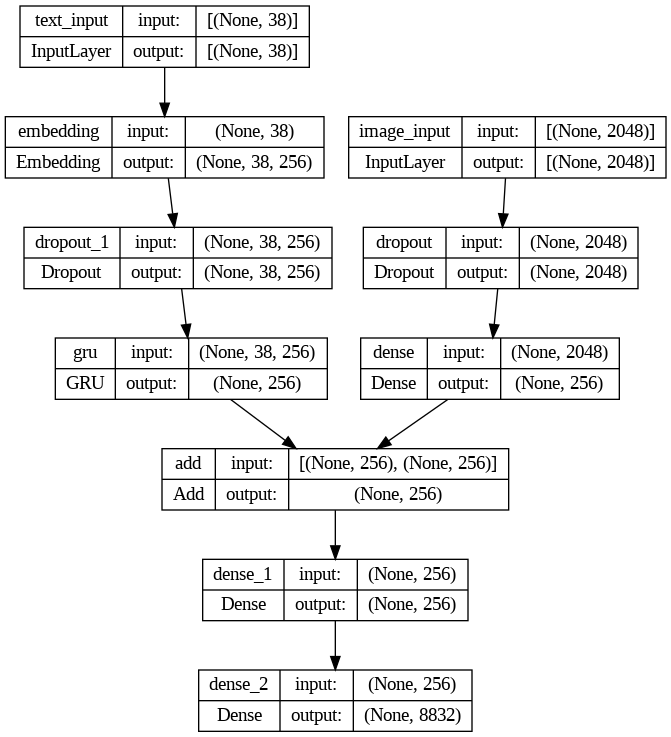

In [13]:
# Define the GRU model
image_input = Input(shape=(2048,), name="image_input")
image_dropout = Dropout(0.4)(image_input)
image_dense = Dense(256, activation='relu')(image_dropout)

# Sequence feature layers
caption_input = Input(shape=(max_length,), name="text_input")
caption_embedding = Embedding(vocab_size, 256, mask_zero=True)(caption_input)
caption_dropout = Dropout(0.4)(caption_embedding)
# GRU Layer
gru_layer = GRU(256)(caption_dropout)

# Decoder model
decoder_concat = Add()([image_dense, gru_layer])
decoder_dense = Dense(256, activation='relu')(decoder_concat)
decoder_output = Dense(vocab_size, activation='softmax')(decoder_dense)

# Define the GRU model
gru_model = Model(inputs=[image_input, caption_input], outputs=decoder_output)
gru_model.compile(loss='categorical_crossentropy', optimizer='adam')

# Plot the GRU model
plot_model(gru_model, show_shapes=True)

In [14]:
# Training GRU Model for 30 Epochs
batch_size = 32
epochs = 30
generator=img_cap_batch_generator(image_ids, processed_captions, image_features, tokenizer, max_length, vocab_size, batch_size)
history = gru_model.fit(generator,steps_per_epoch=len(image_ids)//batch_size, epochs=epochs)

Epoch 1/30
252/252 [==============================] - 42s 142ms/step - loss: 4.5439
Epoch 2/30
252/252 [==============================] - 31s 124ms/step - loss: 3.3866
Epoch 3/30
252/252 [==============================] - 31s 123ms/step - loss: 3.0388
Epoch 4/30
252/252 [==============================] - 31s 124ms/step - loss: 2.8326
Epoch 5/30
252/252 [==============================] - 31s 123ms/step - loss: 2.6827
Epoch 6/30
252/252 [==============================] - 31s 123ms/step - loss: 2.5641
Epoch 7/30
252/252 [==============================] - 31s 122ms/step - loss: 2.4717
Epoch 8/30
252/252 [==============================] - 31s 123ms/step - loss: 2.3953
Epoch 9/30
252/252 [==============================] - 31s 122ms/step - loss: 2.3290
Epoch 10/30
252/252 [==============================] - 31s 122ms/step - loss: 2.2714
Epoch 11/30
252/252 [==============================] - 31s 124ms/step - loss: 2.2213
Epoch 12/30
252/252 [==============================] - 31s 123ms/step - lo

In [25]:
# Save the model
'''
gru_model.save("/content/drive/MyDrive/gru_model.h5")
# Load the model
#loaded_model = load_model("gru_model.h5")
'''

## RNN Model

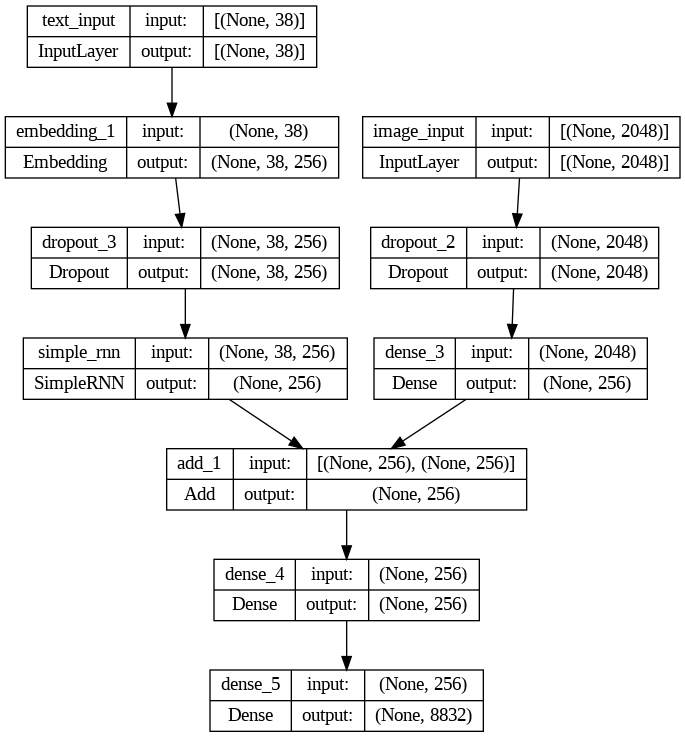

In [15]:
# Define RNN model
image_input = Input(shape=(2048,), name="image_input")
image_dropout = Dropout(0.4)(image_input)
image_dense = Dense(256, activation='relu')(image_dropout)

# Sequence feature layers
text_input = Input(shape=(max_length,), name="text_input")
text_embedding = Embedding(vocab_size, 256, mask_zero=True)(text_input)
text_dropout = Dropout(0.4)(text_embedding)
text_rnn = SimpleRNN(256)(text_dropout)  # RNN layer

# Decoder model
decoder_concat = Add()([image_dense, text_rnn])
decoder_dense = Dense(256, activation='relu')(decoder_concat)
decoder_output = Dense(vocab_size, activation='softmax')(decoder_dense)

# Create RNN model
rnn_model = Model(inputs=[image_input, text_input], outputs=decoder_output)
rnn_model.compile(loss='categorical_crossentropy', optimizer='adam')

# Plot the model
plot_model(rnn_model, show_shapes=True)


In [16]:
# Training RNN Model for 30 Epochs
batch_size = 32
epochs = 30
generator=img_cap_batch_generator(image_ids, processed_captions, image_features, tokenizer, max_length, vocab_size, batch_size)
history = rnn_model.fit(generator,steps_per_epoch=len(image_ids)//batch_size, epochs=epochs)

Epoch 1/30
252/252 [==============================] - 35s 127ms/step - loss: 4.5347
Epoch 2/30
252/252 [==============================] - 31s 123ms/step - loss: 3.4146
Epoch 3/30
252/252 [==============================] - 32s 127ms/step - loss: 3.0950
Epoch 4/30
252/252 [==============================] - 32s 125ms/step - loss: 2.8906
Epoch 5/30
252/252 [==============================] - 31s 124ms/step - loss: 2.7360
Epoch 6/30
252/252 [==============================] - 31s 125ms/step - loss: 2.6108
Epoch 7/30
252/252 [==============================] - 31s 125ms/step - loss: 2.5144
Epoch 8/30
252/252 [==============================] - 31s 124ms/step - loss: 2.4394
Epoch 9/30
252/252 [==============================] - 32s 125ms/step - loss: 2.3732
Epoch 10/30
252/252 [==============================] - 31s 124ms/step - loss: 2.3169
Epoch 11/30
252/252 [==============================] - 31s 124ms/step - loss: 2.2666
Epoch 12/30
252/252 [==============================] - 31s 124ms/step - lo

In [27]:
#Save the model
'''
rnn_model.save("/content/drive/MyDrive/rnn_model.h5")
# Load the model
#loaded_model = load_model("rnn_model.h5")
'''

## Bi-Directional RNN with Attention

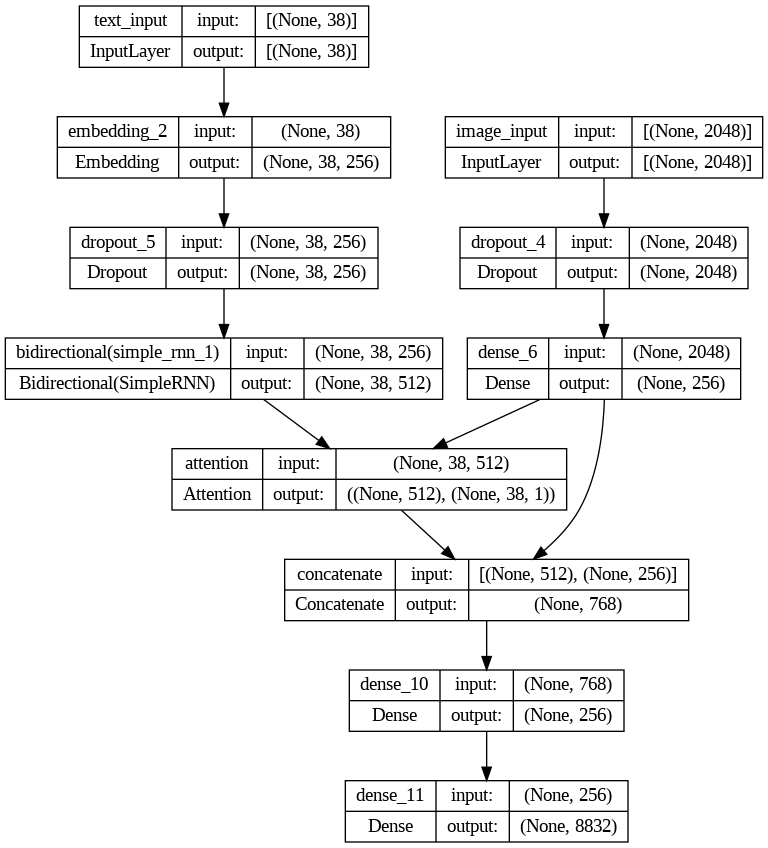

In [17]:
# Define the Attention layer
class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        # Initialize the weight matrices and biases
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, features, hidden):
        # Expand the dimensions of the hidden state
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        # Calculate attention scores
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        # Calculate attention weights
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        # Calculate the context vector
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

# Define the input layers
image_input = Input(shape=(2048,), name="image_input")
text_input = Input(shape=(max_length,), name="text_input")

# Image feature layers
image_dropout = Dropout(0.4)(image_input)
image_dense = Dense(256, activation='relu')(image_dropout)

# Sequence feature layers
text_embedding = Embedding(vocab_size, 256, mask_zero=True)(text_input)
text_dropout = Dropout(0.4)(text_embedding)

# Bidirectional RNN
rnn = Bidirectional(SimpleRNN(256, return_sequences=True))(text_dropout)

# Attention mechanism
context_vector, attention_weights = Attention(256)(rnn, image_dense)
decoder_concat = Concatenate()([context_vector, image_dense])

# Decoder layers
decoder_dense = Dense(256, activation='relu')(decoder_concat)
decoder_output = Dense(vocab_size, activation='softmax')(decoder_dense)

# Create the model
bi_rnn_attention_model = Model(inputs=[image_input, text_input], outputs=decoder_output)

# Compile the model
bi_rnn_attention_model.compile(loss='categorical_crossentropy', optimizer='adam')

# Plot the model
plot_model(bi_rnn_attention_model, show_shapes=True)


In [18]:
# Training Bi-RNN Model for 30 Epochs
batch_size = 32
epochs = 30
generator=img_cap_batch_generator(image_ids, processed_captions, image_features, tokenizer, max_length, vocab_size, batch_size)
history = bi_rnn_attention_model.fit(generator,steps_per_epoch=len(image_ids)//batch_size, epochs=epochs)

Epoch 1/30
252/252 [==============================] - 44s 155ms/step - loss: 4.7741
Epoch 2/30
252/252 [==============================] - 33s 130ms/step - loss: 3.6347
Epoch 3/30
252/252 [==============================] - 32s 127ms/step - loss: 3.2604
Epoch 4/30
252/252 [==============================] - 32s 127ms/step - loss: 3.0361
Epoch 5/30
252/252 [==============================] - 32s 127ms/step - loss: 2.8665
Epoch 6/30
252/252 [==============================] - 32s 127ms/step - loss: 2.7342
Epoch 7/30
252/252 [==============================] - 32s 128ms/step - loss: 2.6237
Epoch 8/30
252/252 [==============================] - 32s 128ms/step - loss: 2.5320
Epoch 9/30
252/252 [==============================] - 32s 127ms/step - loss: 2.4609
Epoch 10/30
252/252 [==============================] - 33s 129ms/step - loss: 2.4015
Epoch 11/30
252/252 [==============================] - 32s 128ms/step - loss: 2.3453
Epoch 12/30
252/252 [==============================] - 32s 127ms/step - lo

In [29]:
# Save the model
'''
bi_rnn_attention_model.save("/content/drive/MyDrive/bi_rnn_attention_model.h5")
# Load the model
#loaded_model = load_model("bi_rnn_attention_model.h5")
'''

## Image Caption Generation and Comparison

In [19]:
def index_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

models={"GRU          ":gru_model,"RNN          ": rnn_model, "Attention RNN": bi_rnn_attention_model}

def generate_caption(image_name, models=models):
    image_id = image_name.split('.')[0]
    image_path = os.path.join(directory, image_name)
    image = Image.open(image_path)

    # Resize image to have same aspect ratio
    aspect_ratio = 1
    width = min(image.size[0], int(aspect_ratio * image.size[1]))
    height = int(width / aspect_ratio)
    image = image.resize((width, height))

    # Display image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Print actual caption (1st caption)
    print("Actual Caption:", processed_captions[image_id][0])
    # Predict and display captions for each model
    for model_name, model in models.items():
        predicted_caption = 'sos'
        for _ in range(max_length):
            sequence = tokenizer.texts_to_sequences([predicted_caption])[0]
            sequence = pad_sequences([sequence], max_length)
            y_pred = model.predict([image_features[image_id], sequence], verbose=0)
            y_pred = np.argmax(y_pred)
            predicted_word = index_to_word(y_pred, tokenizer)
            if predicted_word is None:
                break
            predicted_caption += " " + predicted_word
            if predicted_word == 'eos':
                break
        print(f'{model_name}: {predicted_caption}')
    print()

def display_random_images(num_images=5):
    # Get a list of all image filenames in the directory
    image_filenames = os.listdir(directory)
    # Randomly select 'num_images' images
    selected_images = random.sample(image_filenames, num_images)
    # Display images and captions
    for image_name in selected_images:
        generate_caption(image_name)


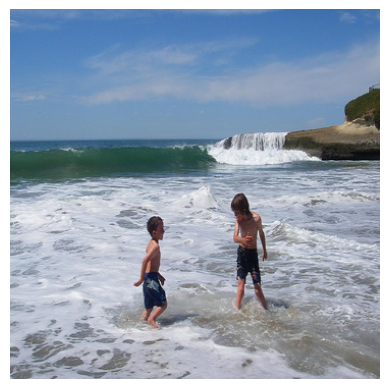

Actual Caption: sos two boys playing in the surf on the beach eos
GRU          : sos two girls wade in the ocean eos
RNN          : sos a man and a woman are playing in the ocean eos
Attention RNN: sos a man and a woman in a bathing suits are playing on the beach eos



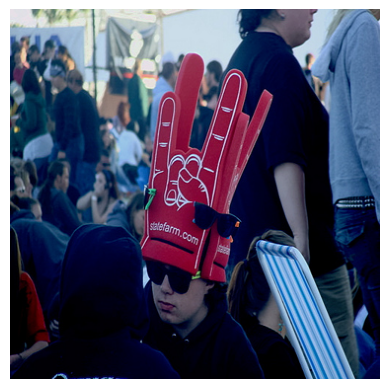

Actual Caption: sos a boy wears a foam hat to show support for his team at a game eos
GRU          : sos a man in a red shirt is holding a beer to a crowd eos
RNN          : sos a man in a statefarmcom hat and sunglasses eos
Attention RNN: sos a man in a red shirt and army cap stands in front of a crowd eos



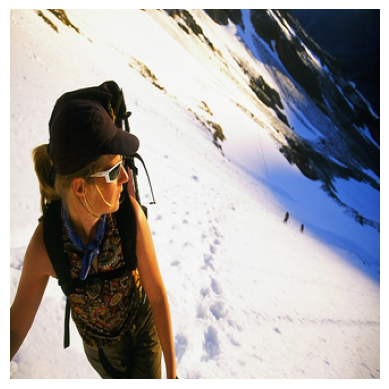

Actual Caption: sos a hiker moves up a snowy mountain eos
GRU          : sos a girl in a pick hat is backpacking through a snowy pool eos
RNN          : sos a woman wearing a helmet is backpacking up a snowy mountain eos
Attention RNN: sos a woman with a camera on a snowy peak eos



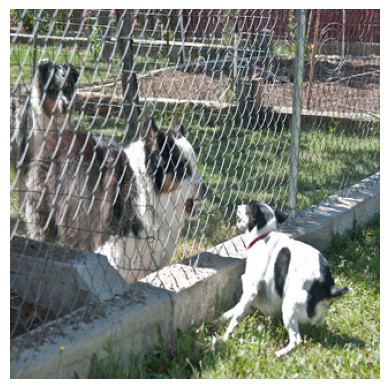

Actual Caption: sos a big dog barking at a small dog through a fence eos
GRU          : sos a black and white dog is running through a fence eos
RNN          : sos a black and white dog is running through a fence eos
Attention RNN: sos a black and white dog is playing in a park eos



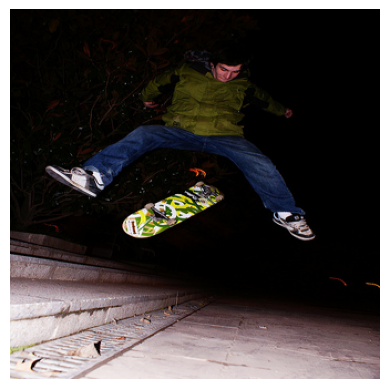

Actual Caption: sos a man jumps over a staircase with a skateboard  doing a trick eos
GRU          : sos a skateboarder in the air eos
RNN          : sos a man in a black and black helmet doing tricks on a skateboard eos
Attention RNN: sos a man in a green shirt does tricks on his skateboard eos



In [32]:
# Display 5 randomly selected images and generated captions
display_random_images(num_images=5)